# Introdução

Neste trabalho, feito para disciplina Introdução a Computação Visual ministrada pelo professor William Robson Schwartz, foram implementados compressores de imagem utilizando diferentes técnicas de redundância.

Alunos participantes do trabalho:
- Lucas Junqueira Carvalhido - 2022043264
- Felipe Lopes Gomide - 2022043213
- Leonardo Romano Andrade - 2023075151 

Redundâncias implementadas para compressão de imagens:
- Redundância de Codificação
    - Codificação de Huffman
- Redundância Inter-Pixel
    - Preditor
    - Transformada Discreta de Cosseno (DCT)
    - Transformada de Fourier (DFT)
- Redundância Psico-Visual
    - Quantização

# Bibliotecas

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pickle
import os
import heapq
from collections import Counter
import numpy as np
import heapq
from bitarray import bitarray

# Métricas de Erro

In [2]:
# Root Mean Square Error
def rmse_metric(img1, img2):
    return np.sqrt(np.mean((img1.astype("float") - img2.astype("float")) ** 2))

# Coleta das Imagens de Teste

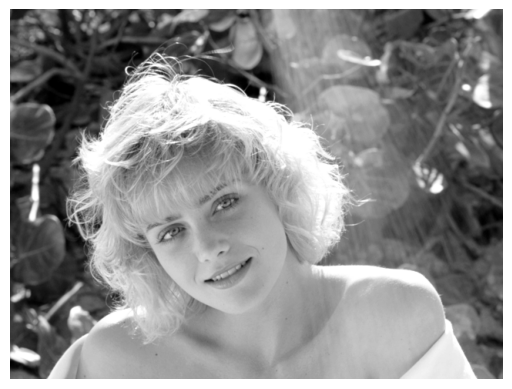

In [3]:
# Carregar a imagem em modo grayscale
imagem = cv2.imread('images/pgm_bin/marcie.pgm', cv2.IMREAD_GRAYSCALE)

# Exibindo imagem
plt.imshow(imagem, cmap='gray')
plt.axis('off') 
plt.show()

In [4]:
# Shape da Imagem
imagem.shape

(480, 640)

# Implementação JPEG 

Neste parte do trabalho será implementada a compressão JPEG de dois modos distintos para fins de comparação. No primeiro modo, será implementada a compressão JPEG classica, seguindo os seguintes passos:

- Compressão:
    1. Imagem subdividida em blocos de 8x8 pixels.
    2. Transformada DCT.
    3. Quantização com uma matriz de quantização pré-definida.
    4. Ordenação Zigue-Zague
    5. Codificação de Huffman

- Descompressão:
    1. Decodificação de Huffman
    2. Desquantização
    3. Transformada inversa DCT (IDCT)

No segundo modo, será implementada a compressão utilizando a transformada de Fourier (DFT) ao invés da Transformada Discreta do Cosseno (DCT), seguindo os seguintes passos:

- Compressão:
    1. Imagem subdividida em blocos de 8x8 pixels.
    2. Transformada DFT.
    3. Quantização com uma matriz de quantização pré-definida.
    4. Codificação de Huffman

- Descompressão:
    1. Decodificação de Huffman
    2. Desquantização
    3. Transformada inversa DFT (IDFT)

Depois, com a realização de testes, se poderá visualizar na prática qual das duas transformadas é mais eficiente na prática de compressão de imagens.

## Implementação da transformada DCT e da transformada inversa IDCT

Esta etapa realiza a **Transformada Discreta do Cosseno (DCT)** e sua inversa (**IDCT**) em uma imagem em escala de cinza, utilizando blocos de `8x8`, e avalia a qualidade da reconstrução utilizando as métricas **RMSE** e **PSNR**.

---

- Funções

  - `dct_transform(img, step=8)`
  Aplica a DCT em blocos de `step x step` (padrão `8x8`) da imagem.

    - **Parâmetros:**
      - `img`: imagem de entrada (matriz 2D).
      - `step`: tamanho do bloco (padrão: 8).
    - **Retorna:** matriz com os coeficientes DCT da imagem.

  - `idct_transform(dct_coefs, step=8)`
  Aplica a **transformada inversa DCT (IDCT)** para reconstruir a imagem a partir dos coeficientes DCT.

    - **Parâmetros:**
      - `dct_coefs`: matriz com os coeficientes DCT.
      - `step`: tamanho do bloco (padrão: 8).
    - **Retorna:** imagem reconstruída.

---

- Processamento

  1. **Pré-processamento da Imagem:**
    - Cópia da imagem original.
    - Conversão para `float`.
    - Deslocamento dos valores de pixel (`img - 128`) para centralizar em torno de zero.

  2. **Aplicação da DCT e IDCT:**
    - A DCT é aplicada usando `cv2.dct()` bloco a bloco.
    - A imagem é reconstruída com `cv2.idct()`.
    - Após a IDCT, desfaz-se o deslocamento adicionando 128.

---

- Visualização

  Exibe 3 imagens lado a lado:
    1. **Imagem Original**
    2. **Imagem Reconstruída**
    3. **Coeficientes DCT** (com escala logarítmica para melhor visualização)

---

- Avaliação

    Duas métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).


In [5]:
# Função que realiza a transformada DCT
def dct_transform(img, step=8):

    size = img.shape                    # Shape da imagem
    DCT = np.zeros(size, dtype=float)   # Cria uma matriz para armazenar os coeficientes DCT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            dct = cv2.dct(img[y:y+step, x:x+step])   # Aplica DCT no bloco 8x8

            DCT[y:y+step, x:x+step] = dct     # Salva o bloco DCT

    return DCT

# Função que realiza a inversa da DCT (IDCT)
def idct_transform(dct_coefs, step=8):

    size = dct_coefs.shape
    IDCT = np.zeros(size, dtype=float)  # Cria uma matriz para armazenar a imagem reconstruída

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            idct = cv2.idct(dct_coefs[y:y+step, x:x+step]) # Aplica IDCT 2D no bloco 8x8

            IDCT[y:y+step, x:x+step] = idct   # Salva o bloco reconstruído
    
    IDCT = IDCT + 128 # Desfaz o deslocamento de 128

    return IDCT

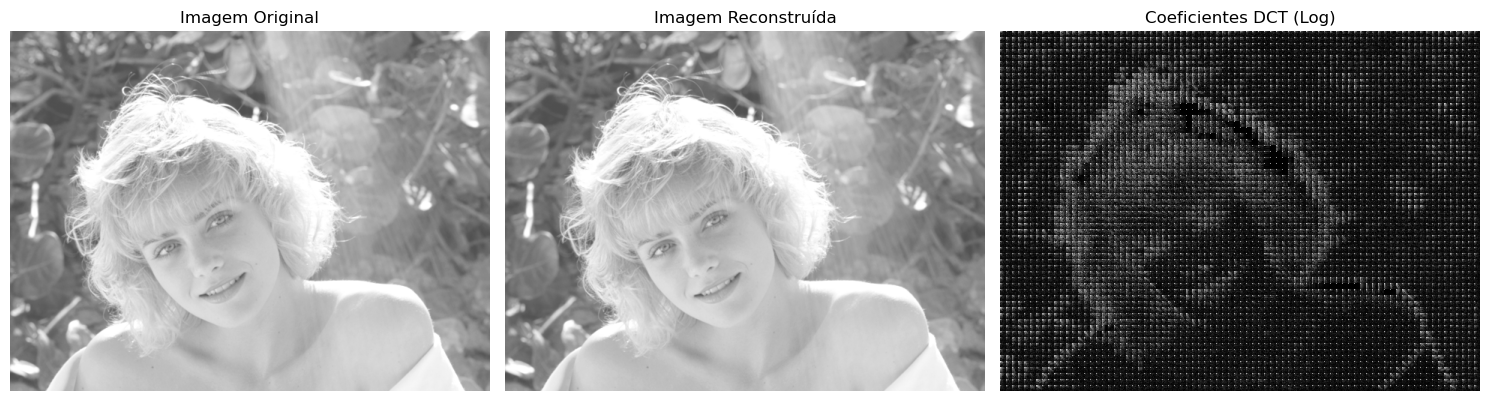

In [6]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Realiza Transformada
DCT = dct_transform(img, step)

# Realiza a Transformada Inversa
IDCT = idct_transform(DCT, step)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDCT, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

# Coeficientes DCT
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(DCT) + 1), cmap='gray')
plt.title('Coeficientes DCT (Log)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Métricas de Erro
rmse = rmse_metric(img, IDCT)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDCT)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 1.9735972688114828e-14
Métrica PSNR: 322.12845571680845 dB


## Implementação da transformada DFT e da transformada inversa IDFT

Nesta etapa é aplicado a **Transformada Discreta de Fourier (DFT)** em blocos `8x8` de uma imagem em escala de cinza, reconstruindo-a em seguida com a **IDFT**, e avaliando a qualidade da reconstrução com as métricas **RMSE** e **PSNR**.

---

- Funções

    - `dft_transform(img, step=8)`
    Aplica a DFT 2D em blocos `step x step` da imagem.

        - **Parâmetros:**
        - `img`: imagem de entrada (matriz 2D).
        - `step`: tamanho do bloco (padrão: 8).
        - **Retorna:**
        - `DFT_REAL`: parte real dos coeficientes DFT.
        - `DFT_IM`: parte imaginária dos coeficientes DFT.
        - `dft_magnitude`: magnitude dos coeficientes, usada para visualização.

    - `idft_transform(dft_coefs_real, dft_coefs_im, step=8)`
    Aplica a **transformada inversa (IDFT)** para reconstruir a imagem a partir dos coeficientes reais e imaginários da DFT.

        - **Parâmetros:**
        - `dft_coefs_real`: matriz com os coeficientes reais da DFT.
        - `dft_coefs_im`: matriz com os coeficientes imaginários da DFT.
        - `step`: tamanho do bloco (padrão: 8).
        - **Retorna:**
        - `IDFT_REAL`: parte real da imagem reconstruída.
        - `IDFT_IM`: parte imaginária (residual) da imagem reconstruída.
        - `idft_magnitude`: magnitude da reconstrução (não usada diretamente na visualização).

---

- Processamento

    1. **Pré-processamento da Imagem:**
    - A imagem é copiada, convertida para `float`, e centralizada (`img - 128`) para facilitar a aplicação da DFT.

    2. **Transformada de Fourier (DFT):**
    - Cada bloco `8x8` da imagem recebe `cv2.dft()` com `DFT_COMPLEX_OUTPUT`, retornando coeficientes reais e imaginários.
    - A magnitude dos coeficientes é computada com `cv2.magnitude()` e transformada em escala logarítmica para visualização.

    3. **Transformada Inversa (IDFT):**
    - Os coeficientes reais e imaginários são recombinados com `cv2.merge()`.
    - A IDFT é aplicada com `cv2.idft()` e escalonada com `DFT_SCALE`.
    - O deslocamento de 128 é restaurado.

---

- Visualização

    Três imagens são exibidas lado a lado:

    1. **Imagem Original**
    2. **Imagem Reconstruída após IDFT**
    3. **Magnitude da DFT (com escala logarítmica)**

---

- Avaliação

    Duas métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).


In [8]:
def dft_transform(img, step=8):

    size = img.shape
    DFT_REAL = np.zeros(size, dtype=float)    # Matriz para armazenar coeficientes reais da DFT
    DFT_IM = np.zeros(size, dtype=float)      # Matriz para armazenar coeficientes imaginarios da DFT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            # Aplica DFT 2D no bloco 8x8
            dft = cv2.dft(np.float32(img[y:y+step, x:x+step]), flags=cv2.DFT_COMPLEX_OUTPUT)

            DFT_REAL[y:y+step, x:x+step] = dft[:, :, 0]  # Salva o bloco DFT Real
            DFT_IM[y:y+step, x:x+step] = dft[:, :, 1]    # Salva o bloco DFT Imaginario

    # Magnitude da DFT
    dft_magnitude = cv2.magnitude(DFT_REAL, DFT_IM)

    return DFT_REAL, DFT_IM, dft_magnitude

def idft_transform(dft_coefs_real, dft_coefs_im, step=8):

    size = dft_coefs_real.shape
    IDFT_REAL = np.zeros(size, dtype=float)   # Matriz para armazenar coeficientes reais da IDFT
    IDFT_IM = np.zeros(size, dtype=float)     # Matriz para armazenar coeficientes imaginarios da IDFT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8

            dft = cv2.merge([dft_coefs_real[y:y+step, x:x+step], dft_coefs_im[y:y+step, x:x+step]])    # Junta os coefs reais e imaginários
            idft = cv2.idft(dft, flags=cv2.DFT_SCALE)                               # Aplica IDFT no bloco transformado

            IDFT_REAL[y:y+step, x:x+step] = idft[:, :, 0]     # Salva o bloco IDFT Real
            IDFT_IM[y:y+step, x:x+step] = idft[:, :, 1]     # Salva o bloco Imaginario
    
    # Magnitude da IDFT
    idft_magnitude = cv2.magnitude(IDFT_REAL, IDFT_IM)
    
    # Desfaz o deslocamento de 128
    IDFT_REAL = IDFT_REAL + 128

    return IDFT_REAL, IDFT_IM, idft_magnitude

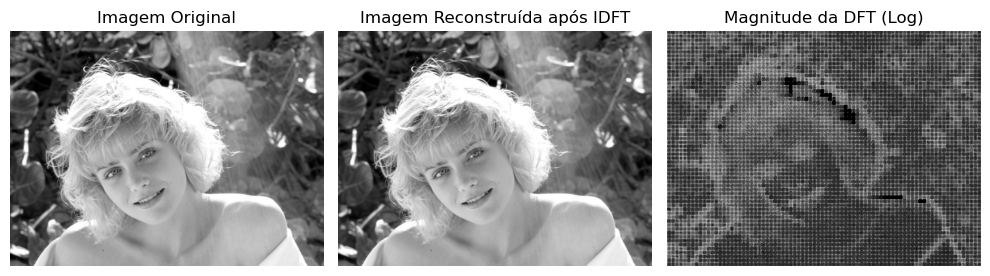

In [9]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Realiza a transformada DFT
DFT_REAL, DFT_IM, dft_magnitude = dft_transform(img, step)
log_magnitude = np.log(dft_magnitude + 1) # Aplicando log para melhorar a visualização

# Realiza a transformada inversa IDFT
IDFT_REAL, IDFT_IM, idft_magnitude = idft_transform(DFT_REAL, DFT_IM, step)

# Desfaz o deslocamento de 128
img = img + 128

# Visualizar a imagem original e a reconstruída após a IDFT
plt.figure(figsize=(10, 7))

# Imagem original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

# Magnitude da DFT
plt.subplot(1, 3, 3)
plt.imshow(log_magnitude, cmap='gray')
plt.title('Magnitude da DFT (Log)')
plt.axis('off')

# Imagem reconstruída após a IDFT
plt.subplot(1, 3, 2)
plt.imshow(IDFT_REAL, cmap='gray')
plt.title('Imagem Reconstruída após IDFT')
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Métricas de Erro
rmse = rmse_metric(img, IDFT_REAL)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDFT_REAL)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 5.440281517250006e-07
Métrica PSNR: 173.41837613240259 dB


## Implementação da função de quantização para a transformada DCT

Nesta etapa são aplicados **quantização** e **desquantização** em blocos da **Transformada Discreta do Cosseno (DCT)** de uma imagem, simulando um processo similar ao da compressão JPEG. Após reconstruir a imagem com a **IDCT**, são calculadas as métricas de qualidade **RMSE** e **PSNR**.

---

- Funções

    - `quantizacao_DCT(DCT, QM, step=8)`
    Aplica a **quantização** dos coeficientes DCT com base em uma matriz de quantização (QM).

        - **Parâmetros:**
        - `DCT`: matriz da transformada DCT da imagem.
        - `QM`: matriz de quantização `8x8` (como a do padrão JPEG).
        - `step`: tamanho dos blocos (padrão: 8).
        - **Retorna:**
        - `quant_coefs`: coeficientes DCT quantizados.
        - `dc_array`: array contendo os coeficientes DC (posição [0,0]) originais de cada bloco.

    - `desquantization_DCT(quant_coefs, dc_array, QM, useDC=True, step=8)`
    Desfaz o processo de quantização, restaurando os coeficientes DCT aproximados.

        - **Parâmetros:**
        - `quant_coefs`: coeficientes quantizados.
        - `dc_array`: lista com os coeficientes DC originais (opcionalmente utilizados).
        - `QM`: matriz de quantização.
        - `useDC`: define se o coeficiente DC original deve ser restaurado (padrão: `True`).
        - `step`: tamanho dos blocos.
        - **Retorna:**
        - `original_coefs`: matriz com os coeficientes DCT restaurados.

---

- Processamento

    1. **Pré-processamento da Imagem:**
    - A imagem é convertida para `float` e centralizada com `img - 128`.

    2. **Matriz de Quantização:**
    - Uma matriz padrão JPEG `8x8` é usada, contendo valores maiores para frequências mais altas (favorecendo compressão).

    3. **Transformada DCT:**
    - Aplicada em blocos `8x8` com a função `dct_transform()` (supondo definida anteriormente).

    4. **Quantização:**
    - Cada bloco DCT é dividido pela matriz de quantização e arredondado.
    - O coeficiente DC original é armazenado separadamente.

    5. **Desquantização:**
    - Os coeficientes quantizados são multiplicados pela matriz de quantização.
    - O coeficiente DC original é reintroduzido se `useDC=True`.

    6. **Transformada Inversa (IDCT):**
    - Os coeficientes desquantizados são transformados de volta ao domínio espacial com `idct_transform()`.

    7. **Pós-processamento:**
    - O valor `128` é somado novamente à imagem reconstruída para desfazer o deslocamento inicial.

---

- Visualização

São exibidas as seguintes imagens lado a lado:

1. **Imagem Original**
2. **Imagem Reconstruída após Quantização e IDCT**

---

- Avaliação

    Duas métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).

In [11]:
def quantizacao_DCT(DCT, QM, step=8):
    
    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = DCT.shape
    quant_coefs = np.zeros(size, dtype=float) # Matriz para armazenar os coeficientes quantizados
    dc_array = []                             # Array para armazenar os coeficientes DC originais
    
    for y in range(0,size[0],step):
        for x in range(0,size[1],step):

            dct = DCT[y:y+step, x:x+step]

            DC = dct[0,0]            # Adquire o coeficiente DC
            dct = np.divide(dct, QM) # Divive a DCT pela matriz de quantização
            dct = dct.round()        # Arredondamento da matriz quantizada

            quant_coefs[y:y+step, x:x+step] = dct # Salva o bloco quantizado
            dc_array.append(DC)
    
    return quant_coefs, dc_array

def desquantization_DCT(quant_coefs, dc_array, QM, useDC=True, step=8):

    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = quant_coefs.shape
    original_coefs = np.zeros(size, dtype=float)

    for y in range(0,size[0],step):
        for x in range(0,size[1],step):
            # Multiplica a matriz quantizada pela matriz de quantização
            dct = np.multiply(quant_coefs[y:y+step, x:x+step], QM)

            if (useDC == True):
                dct[0,0] = dc_array[0]  # Recupera o coeficiente DC original
                dc_array = dc_array[1:] # Retira o primeiro elemento do array
        
            original_coefs[y:y+step, x:x+step] = dct
    
    return original_coefs

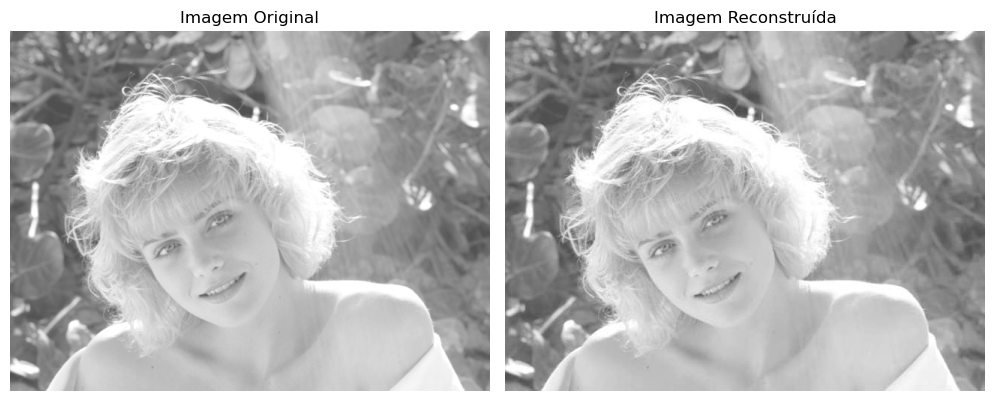

In [12]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Matriz de Quantização
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

# Realiza Transformada DCT
DCT = dct_transform(img, step)

# Quantização
quant_coefs, dc_array = quantizacao_DCT(DCT, QM)

# Desquantização
original_coefs = desquantization_DCT(quant_coefs, dc_array, QM)

# Realiza a Transformada Inversa
IDCT = idct_transform(original_coefs, step)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDCT, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Métricas de Erro
rmse = rmse_metric(img, IDCT)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDCT)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 2.728205166809998
Métrica PSNR: 39.4132630671207 dB


## Implementação da função de quantização para a transformada DFT

Nesta etapa é aplicado um processo de **quantização** sobre a **Transformada Discreta de Fourier (DFT)** de uma imagem, especificamente sobre a **magnitude** dos coeficientes, preservando a **fase**. A imagem é então reconstruída com base na **desquantização** e transformada inversa. Esse processo simula compressão no domínio da frequência com perda controlada.

---

- Funções

    - `quantizacao_DFT(DFT_REAL, DFT_IM, QM, step=8)`
    Aplica quantização na **magnitude** dos coeficientes DFT, bloco a bloco.

        - **Parâmetros:**
        - `DFT_REAL`, `DFT_IM`: partes real e imaginária da DFT da imagem.
        - `QM`: matriz de quantização `8x8` (padrão JPEG).
        - `step`: tamanho dos blocos (padrão: 8).
        - **Processo:**
        - Calcula **magnitude** e **fase** dos coeficientes DFT usando `cv2.magnitude()` e `cv2.phase()`.
        - Divide a magnitude pelo QM e arredonda (quantização).
        - **Retorna:**
        - `magnitude_quant`: magnitude quantizada.
        - `phase`: matriz de fases original (preservada para reconstrução).

    - `desquantizacao_DFT(magnitude_quant, phase, QM, step=8)`
    Reconstrói as partes real e imaginária da DFT com base na magnitude quantizada e fase original.

        - **Parâmetros:**
        - `magnitude_quant`: magnitude quantizada.
        - `phase`: fase original dos coeficientes DFT.
        - `QM`: matriz de quantização.
        - `step`: tamanho dos blocos.
        - **Processo:**
        - Multiplica cada bloco da magnitude quantizada pela QM.
        - Reconstroi partes real e imaginária usando:
            - `real = magnitude × cos(fase)`
            - `imag = magnitude × sin(fase)`
        - **Retorna:**
        - `original_dft_real`, `original_dft_im`: partes real e imaginária da DFT restauradas.

---

- Processamento da Imagem

    1. **Pré-processamento:**
    - Converte imagem para `float` e centraliza os valores com `img - 128`.

    2. **Matriz de Quantização:**
    - Matriz JPEG padrão usada para definir a granularidade da quantização.

    3. **Transformada DFT:**
    - A DFT é aplicada por bloco (8x8), com funções `DFT_REAL`, `DFT_IM`, assumidas como resultado da função `dft_transform()` (não mostrada no código).

    4. **Quantização:**
    - É aplicada apenas à **magnitude** dos coeficientes da DFT.
    - A fase é preservada sem alterações.

    5. **Desquantização:**
    - A magnitude é reescalada.
    - Usando a fase original, são reconstruídos os coeficientes DFT (parte real e imaginária).

    6. **Transformada Inversa (IDFT):**
    - Reverte os coeficientes DFT para o domínio espacial (imagem reconstruída) com `idft_transform()`.

    7. **Pós-processamento:**
    - O deslocamento de 128 é desfeito com `img + 128`.

---

- Visualização

    São exibidas duas imagens:

    1. **Imagem Original**: após o deslocamento reverso.
    2. **Imagem Reconstruída**: a partir da DFT quantizada e desquantizada.

---

- Avaliação

    Duas métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).


In [14]:
def quantizacao_DFT(DFT_REAL, DFT_IM, QM, step=8):

    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = DFT_REAL.shape
    magnitude_quant = np.zeros(size, dtype=float)
    phase_quant = np.zeros(size, dtype=float)

    magnitude = cv2.magnitude(DFT_REAL, DFT_IM)
    phase = cv2.phase(DFT_REAL, DFT_IM)

    for y in range(0,size[0],step):
        for x in range(0,size[1],step):

            # Realizando quantização no bloco da matriz de magnitude
            magnitude_bloco = np.divide(magnitude[y:y+step, x:x+step], QM) # Divive pela matriz de quantização
            magnitude_bloco = magnitude_bloco.round()                      # Arredondamento da matriz quantizada
            phase_bloco = np.divide(phase[y:y+step, x:x+step], QM) # Divive pela matriz de quantização
            phase_bloco = phase_bloco.round()                      # Arredondamento da matriz quantizada
            

            magnitude_quant[y:y+step, x:x+step] = magnitude_bloco # Salva o bloco quantizado
            phase_quant[y:y+step, x:x+step] = phase_bloco # Salva o bloco quantizado

    return magnitude_quant, phase_quant

def desquantizacao_DFT(magnitude_quant, phase, QM, step=8):

    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = magnitude_quant.shape
    original_dft_real = np.zeros(size, dtype=float)
    original_dft_im = np.zeros(size, dtype=float)

    for y in range(0,size[0],step):
        for x in range(0,size[1],step):

            # Multiplica a matriz quantizada pela matriz de quantização
            magnitude_bloco = np.multiply(magnitude_quant[y:y+step, x:x+step], QM)
            phase_bloco = np.multiply(phase[y:y+step, x:x+step], QM)
            

            # Reconstrução da matriz de coeficientes reais
            real_bloco = magnitude_bloco * np.cos(phase_bloco)
            im_bloco = magnitude_bloco * np.sin(phase_bloco)

        
            original_dft_real[y:y+step, x:x+step] = real_bloco
            original_dft_im[y:y+step, x:x+step] = im_bloco

    return original_dft_real, original_dft_im

In [15]:
def gerar_matriz_quantizacao_pouco_agressiva(tamanho):
    """
    Gera uma matriz de quantização pouco agressiva de tamanho NxN.

    Args:
        tamanho (int): Dimensão da matriz (NxN).

    Returns:
        numpy.ndarray: Matriz de quantização de tamanho NxN.
    """
    matriz = np.ones((tamanho, tamanho), dtype=float) * 10  # Valores base relativamente altos

    # Reduzir os valores para as baixas frequências (cantos superiores esquerdos)
    for i in range(tamanho):
        for j in range(tamanho):
            frequencia = i + j
            if frequencia <= 2:
                matriz[i, j] = 16
            elif frequencia <= 4:
                matriz[i, j] = 30
            elif frequencia <= 6:
                matriz[i, j] = 70
            # As frequências mais altas permanecem com valores maiores (menos quantização)

    return matriz

QM_DFT = gerar_matriz_quantizacao_pouco_agressiva(8)
QM_DFT = QM_DFT.astype(np.float16)
print(QM_DFT)

[[16. 16. 16. 30. 30. 70. 70. 10.]
 [16. 16. 30. 30. 70. 70. 10. 10.]
 [16. 30. 30. 70. 70. 10. 10. 10.]
 [30. 30. 70. 70. 10. 10. 10. 10.]
 [30. 70. 70. 10. 10. 10. 10. 10.]
 [70. 70. 10. 10. 10. 10. 10. 10.]
 [70. 10. 10. 10. 10. 10. 10. 10.]
 [10. 10. 10. 10. 10. 10. 10. 10.]]


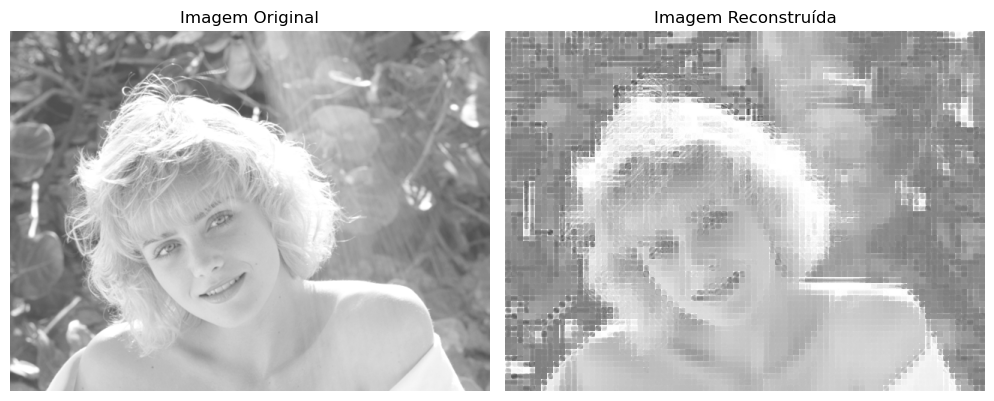

In [16]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Realiza Transformada DFT
IDFT_REAL, IDFT_IM, idft_magnitude = dft_transform(img, step)

# Quantização
magnitude_quant, phase = quantizacao_DFT(DFT_REAL, DFT_IM, QM_DFT)

# Desquantização
original_coefs_real, original_coefs_im = desquantizacao_DFT(magnitude_quant, phase, QM_DFT)

# Realiza a Transformada Inversa
IDFT_REAL, IDFT_IM, magnitude = idft_transform(original_coefs_real, original_coefs_im)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDFT_REAL, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
# Métricas de Erro
rmse = rmse_metric(img, IDFT_REAL)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDFT_REAL)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 23.94596803174591
Métrica PSNR: 20.54615564112101 dB


## Implementação da Codificação Huffman

Nesta etapa do trabalho é implementada a codificação de Huffman, para melhor distribuir os códigos designados para cada pixel da imagem de modo que ela ocupe menos espaço.

---

- Funções

    - `build_huffman_tree(frequencies)`
    Constrói a árvore de Huffman a partir das frequências dos símbolos.

        - **Parâmetros:**
            - frequencies: dicionário com a frequência de cada símbolo ({símbolo: frequência}).
        - **Processo:**
            - Cria uma min-heap de nós (Node) com os símbolos e suas frequências.
            - Iterativamente remove os dois nós com menor frequência e os combina em um novo nó.
            - Repete até restar apenas a raiz da árvore.
        - **Retorna:**
            - root: nó raiz da árvore de Huffman.

    - `generate_huffman_codes(root)`
    Gera os códigos binários de Huffman a partir da árvore.

        - **Parâmetros:**
            - `root`: nó raiz da árvore de Huffman.
        - **Processo:**
        - Percorre a árvore recursivamente:
            - Esquerda → adiciona `"0"` ao caminho.
            - Direita → adiciona `"1"`.
        - Associa cada símbolo ao caminho binário correspondente.
        - **Retorna:**
            - `codes`: dicionário `{símbolo: código_binário}`.
    
    - `huffman_encode(matrix)`  
    Aplica **compressão Huffman** a uma matriz NumPy.

        - **Parâmetros:**
            - `matrix`: matriz NumPy de entrada (ex: imagem ou bloco de dados).
        - **Processo:**
            - Achata a matriz e calcula as frequências dos valores.
            - Constrói a árvore de Huffman e gera os códigos binários.
            - Codifica os símbolos em uma `bitarray` usando os códigos.
        - **Retorna:**
            - `codes`: dicionário com os códigos de Huffman.
            - `encoded_bits`: sequência comprimida como `bitarray`.
    
    - `huffman_decode(dados_comprimidos)`  
    Reconstrói a **matriz original** a partir dos dados Huffman comprimidos.

        - **Parâmetros:**
            - `dados_comprimidos`: dicionário com:
                - `'dados_codificados'`: `bitarray` codificada.
                - `'codigos_huffman'`: dicionário `{símbolo: código}`.
                - `'shape'`: formato original da matriz.
        - **Processo:**
            - Inverte o dicionário de códigos (`{código: símbolo}`).
            - Percorre os bits acumulando até formar um código válido.
            - Reconstrói os símbolos e reorganiza na forma original.
        - **Retorna:**
            - `matriz`: matriz NumPy reconstruída.
    
    - `huffman_decode_dft(dados_comprimidos)`  
    Reconstrói **magnitude** e **fase** comprimidas com Huffman (caso DFT).

        - **Parâmetros:**
            - `dados_comprimidos`: dicionário com:
                - `'dados_codificados_mag'`, `'dados_codificados_phase'`: `bitarray`s codificadas.
                - `'codigos_huffman_mag'`, `'codigos_huffman_phase'`: dicionários de códigos Huffman.
                - `'shape_mag'`, `'shape_phase'`: formatos originais das matrizes.
        - **Processo:**
            - Usa função interna `decode` (similar a `huffman_decode`) para decodificar magnitude e fase separadamente.
        - **Retorna:**
            - `magnitude`: matriz de magnitude reconstruída.
            - `fase`: matriz de fase reconstruída.

In [18]:
class Node:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):  # Necessário para heapq
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    heap = [Node(symbol=sym, freq=freq) for sym, freq in frequencies.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        merged = Node(freq=n1.freq + n2.freq)
        merged.left = n1
        merged.right = n2
        heapq.heappush(heap, merged)

    return heap[0]  # raiz da árvore

def generate_huffman_codes(root):
    codes = {}

    def traverse(node, path=""):
        if node.symbol is not None:
            codes[node.symbol] = path
        else:
            traverse(node.left, path + "0")
            traverse(node.right, path + "1")

    traverse(root)
    return codes

def huffman_encode(matrix):
    dados = matrix.flatten().tolist()
    frequencies = Counter(dados)

    root = build_huffman_tree(frequencies)
    codes = generate_huffman_codes(root)

    # Codificar os dados usando bitarray
    encoded_bits = bitarray()
    for sym in dados:
        encoded_bits.extend(codes[sym])  # Adiciona os bits codificados

    return codes, encoded_bits  # Retorna a codificação como bitarray

def huffman_decode(dados_comprimidos):
    encoded_bits = dados_comprimidos['dados_codificados']
    codes = dados_comprimidos['codigos_huffman']
    shape = dados_comprimidos['shape']

    # Inverter o dicionário: bits -> símbolo
    reverse_codes = {v: k for k, v in codes.items()}
    
    decoded_data = []
    temp = ""
    for bit in encoded_bits:
        temp += str(bit)
        if temp in reverse_codes:
            decoded_data.append(reverse_codes[temp])
            temp = ""  # Reinicia a sequência de bits

    return np.array(decoded_data).reshape(shape)

def huffman_decode_dft(dados_comprimidos):
    def decode(encoded_bits, codes, shape):
        # Inverter o dicionário: bits -> símbolo
        reverse_codes = {v: k for k, v in codes.items()}
        
        decoded_data = []
        temp = ""
        for bit in encoded_bits:
            temp += str(bit)
            if temp in reverse_codes:
                decoded_data.append(reverse_codes[temp])
                temp = ""  # Reinicia a sequência de bits

        return np.array(decoded_data).reshape(shape)

    # Decodificar magnitude
    magnitude = decode(
        dados_comprimidos['dados_codificados_mag'],
        dados_comprimidos['codigos_huffman_mag'],
        dados_comprimidos['shape_mag']
    )
    
    # Decodificar fase
    fase = decode(
        dados_comprimidos['dados_codificados_phase'],
        dados_comprimidos['codigos_huffman_phase'],
        dados_comprimidos['shape_phase']
    )

    return magnitude, fase


## Implementação técnica de Zigue-Zague do JPEG

Nesta estapa é implementado a ordenação zigzag que é utilizada durante a compressão JPEG classica

---

- `zigzag(block)`  
    Converte uma **matriz 8x8** em uma **lista de 64 elementos** usando percurso em **ziguezague** (ordem padrão JPEG).

    - **Parâmetros:**
        - `block`: matriz NumPy `8x8`, geralmente contendo coeficientes DCT.
    - **Processo:**
        - Percorre a matriz em uma sequência zigue-zague: começa no canto superior esquerdo e alterna entre diagonais ascendentes e descendentes.
        - Copia os elementos da matriz para um vetor unidimensional, seguindo essa ordem.
    - **Retorna:**
        - `z`: vetor NumPy de tamanho 64, com os valores do bloco reordenados.

- `inverse_zigzag(array)`  
    Converte uma **lista de 64 elementos** em uma **matriz 8x8**, revertendo o percurso em zigue-zague.

    - **Parâmetros:**
        - `array`: vetor NumPy de 64 elementos, ordenados no formato zigue-zague.
    - **Processo:**
        - Percorre os índices seguindo a mesma lógica da função `zigzag`, mas preenche os elementos na matriz `8x8` em vez de lê-los.
    - **Retorna:**
        - `block`: matriz NumPy `8x8` com os elementos reconstituídos na ordem original.

In [19]:
 # Converte uma matriz 8x8 em uma lista usando o percurso zigue-zague  
def zigzag(block):  
    z = np.empty(64, dtype=block.dtype)
    index = -1
    for i in range(0, 15):
        bound = 0 if i < 8 else i - 7
        for j in range(bound, i - bound + 1):
            if i % 2 == 0:
                x, y = j, i - j
            else:
                x, y = i - j, j
            if x < 8 and y < 8:
                index += 1
                z[index] = block[x][y]
    return z

# Converte uma lista de 64 elementos em uma matriz 8x8 usando percurso zigue-zague inverso
def inverse_zigzag(array):
    block = np.empty((8, 8), dtype=array.dtype)
    index = -1
    for i in range(0, 15):
        bound = 0 if i < 8 else i - 7
        for j in range(bound, i - bound + 1):
            if i % 2 == 0:
                x, y = j, i - j
            else:
                x, y = i - j, j
            if x < 8 and y < 8:
                index += 1
                block[x][y] = array[index]
    return block

## Funções de compressão e descompressão usando a transformada DCT (JPEG clássico)

Nesta etapa do trabalho é simulo o processo de compressão e descompressão de uma imagem em estilo **JPEG**, utilizando:

- **Transformada Discreta do Cosseno (DCT)**
- **Quantização com matriz JPEG padrão**
- **Codificação de Huffman**
- **Ordenação Zig-Zag**

---

- Funções

    - `dct_jpeg_compression(img, file_name, step=8)`
    Executa o pipeline completo de compressão JPEG com DCT e salva os dados comprimidos.

        - **Etapas:**

            1. **Pré-processamento da imagem**
            - Converte para `float`.
            - Subtrai 128 para centralizar os valores no intervalo `[-128, 127]`.

            2. **Matriz de Quantização (QM)**
            - Matriz padrão do JPEG utilizada para compressão com perdas.

            3. **Transformada DCT**
            - Calcula a DCT da imagem com `dct_transform()` (assumida como definida em outro trecho).

            4. **Quantização**
            - Aplica quantização bloco a bloco com `quantizacao_DCT()`:
                - Divide os coeficientes DCT pela QM e arredonda.
                - Extrai também os coeficientes DC (média dos blocos), armazenados separadamente.
            
            5. **Ordenação em zigue-zague**
            - Percorre os blocos em zigue-zague conforme a ordem vista em sala

            6. **Codificação de Huffman**
            - Aplica compressão por entropia com `huffman_encode()`.

            7. **Salvamento dos dados comprimidos**
            - Armazena:
                - Dados codificados,
                - Dicionário Huffman,
                - Shape original da matriz,
                - Vetor `dc_array`.
            - Usa `pickle` para salvar o objeto serializado em `'images/compressed/<file_name>'`.


    - `dct_jpeg_descompression(img_path, step=8)`
    Descomprime a imagem a partir de um arquivo `.huff`.

        - **Etapas:**

            1. **Matriz de Quantização**
            - Mesma QM usada na compressão.

            2. **Leitura dos dados comprimidos**
            - Usa `pickle` para carregar:
                - Dados codificados,
                - Tabela de Huffman,
                - `dc_array`,
                - Shape dos dados.

            3. **Decodificação de Huffman**
            - Reconstrói os coeficientes quantizados com `huffman_decode()`.

            4. **Reverter o zigue-zague**
            - Reverte o processo de zigue-zague

            5. **Desquantização**
            - Usa `desquantization_DCT()` para multiplicar os coeficientes quantizados pela QM e restaurar os valores aproximados originais.

            6. **Transformada Inversa (IDCT)**
            - Reconstrói a imagem no domínio espacial usando `idct_transform()`.

            7. **Retorna** a imagem reconstruída.

---

- Visualização

    Mostra lado a lado:
    - A imagem original (`img`)
    - A imagem descomprimida (`img_rec`)

---

- Avaliação

    Três métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).
    3. Taxa de compressão `Tamanho Original / Tamanho comprimido`


In [20]:
def dump(dados, path):
    bin_string = dados['dados_codificados']
    data_bytes = bitarray(bin_string).tobytes()

    dados['dados_codificados'] = (data_bytes, len(bin_string))

    if (dados.get('dc_array')):
        dados['dc_array'] = np.array(dados['dc_array'], np.float16)
    
    with open(path, 'wb') as f:
        pickle.dump(dados, f)

    print(dados.keys())
    print(f"Dados comprimidos salvos em {path}")

def load(path):
    with open(path, 'rb') as f:
        dados_comprimidos = pickle.load(f)
    
    codigos = dados_comprimidos['dados_codificados']
    bin_string = bitarray(codigos[0]).to01()[:codigos[1]]

    dados_comprimidos['dados_codificados'] = bin_string

    return dados_comprimidos
    

In [21]:
def dct_jpeg_compression(img, file_name, step=8):
    
    img = img.astype(float)             
    img = img - 128                     # Centraliza os valores da imagem em torno de 0

    # Matriz de Quantização
    QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                    [12, 12, 14, 19, 26, 58, 60, 55],
                    [14, 13, 16, 24, 40, 57, 69, 56],
                    [14, 17, 22, 29, 51, 87, 80, 62],
                    [18, 22, 37, 56, 68, 109, 103, 77],
                    [24, 35, 55, 64, 81, 104, 113, 92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103, 99]])

    # 1. Realiza Transformada DCT
    DCT = dct_transform(img)
    
    # 2. Quantização
    quant_coefs, dc_array = quantizacao_DCT(DCT, QM)
    
    # 3. Oredenação Zigue-Zague (Ainda tem que implementar)
    zigzagged_blocks = np.empty_like(quant_coefs)
    for i in range(0, quant_coefs.shape[0], 8):
        for j in range(0, quant_coefs.shape[1], 8):
            block = quant_coefs[i:i+8, j:j+8]
            zigzagged_blocks[i:i+8, j:j+8] = zigzag(block).reshape((8, 8)) 
    
    # 4. Codificação Huffman (Codificação por Entropia)
    codigos_huffman, dados_codificados = huffman_encode(zigzagged_blocks)

    # Salvando dados comprimidos:
    dados_comprimidos = {
        'dados_codificados': dados_codificados,
        'codigos_huffman': codigos_huffman,
        'shape': quant_coefs.shape,
        'dc_array': dc_array
    }
    
    path = os.path.join('images/compressed', file_name)
    dump(dados_comprimidos, path)

    # Desfaz o deslocamento de 128 da imagem
    img = img + 128


def dct_jpeg_descompression(img_path, step=8):

    # Matriz de Quantização
    QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                    [12, 12, 14, 19, 26, 58, 60, 55],
                    [14, 13, 16, 24, 40, 57, 69, 56],
                    [14, 17, 22, 29, 51, 87, 80, 62],
                    [18, 22, 37, 56, 68, 109, 103, 77],
                    [24, 35, 55, 64, 81, 104, 113, 92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103, 99]])

    dados_comprimidos = load(img_path)

    # Coeficientes quantizados e dc_array recuperados
    zigzagged_blocks = huffman_decode(dados_comprimidos)
    dc_array = dados_comprimidos['dc_array']
    shape = dados_comprimidos['shape']

    # Reverter Zigue Zague
    quant_coefs_rec = np.zeros(shape)
    for i in range(0, shape[0], 8):
        for j in range(0, shape[1], 8):
            zigzag_seq = zigzagged_blocks[i:i+8, j:j+8].flatten()
            block = inverse_zigzag(zigzag_seq)
            quant_coefs_rec[i:i+8, j:j+8] = block
    # Desquantização
    original_coefs = desquantization_DCT(quant_coefs_rec, dc_array, QM)

    # Realiza a Transformada Inversa (IDCT)
    img_rec = idct_transform(original_coefs, step)

    return img_rec

In [22]:
# Compressão
img = imagem.copy()
img = img.astype(float)

file_name = 'marcie_comprimida_jpeg_dct.huff'
dct_jpeg_compression(img, file_name)

dict_keys(['dados_codificados', 'codigos_huffman', 'shape', 'dc_array'])
Dados comprimidos salvos em images/compressed/marcie_comprimida_jpeg_dct.huff


In [23]:
# Taxa de compressão
taxa_de_compressao = os.path.getsize("images/pgm_bin/marcie.pgm") / os.path.getsize("images/compressed/marcie_comprimida_jpeg_dct.huff")
print(f"Taxa de compressao = {taxa_de_compressao}")

Taxa de compressao = 4.71152518978606


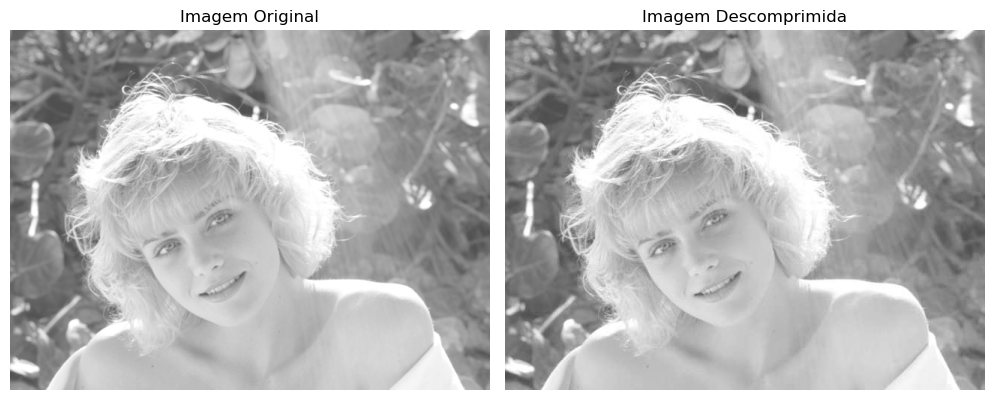

In [24]:
# Descompressão
img_path = 'images/compressed/marcie_comprimida_jpeg_dct.huff'
img_rec = dct_jpeg_descompression(img_path)

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Descomprimida
plt.subplot(1, 3, 2)
plt.imshow(img_rec, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Descomprimida')
plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
# Métricas de Erro
rmse = rmse_metric(img, img_rec)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, img_rec)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 2.728234408601968
Métrica PSNR: 39.41316996942418 dB


## Funções de compressão e descompressão usando a transformada DFT

### Compressão e Descompressão JPEG com DFT + Huffman

Nesta etapa do trabalho é simulo o processo de compressão e descompressão de uma imagem utilizando:

- **Transformada Discreta do Cosseno (DFT)**
- **Quantização das matrizes de Magnitude e Fase**
- **Codificação de Huffman**

---

- `dft_jpeg_compression(img, file_name, QM, step=8)`  
    Realiza a **compressão de imagem** utilizando DFT (Transformada Discreta de Fourier), **quantização JPEG** e **codificação Huffman**.

    - **Parâmetros:**
        - `img`: imagem de entrada (matriz NumPy).
        - `file_name`: nome do arquivo `.pkl` onde os dados comprimidos serão salvos.
        - `QM`: matriz de quantização `8x8` (padrão JPEG).
        - `step`: tamanho dos blocos (padrão: 8).
    - **Processo:**
        1. Converte a imagem para `float` e centraliza os valores (subtrai 128).
        2. Aplica a Transformada Discreta de Fourier (`dft_transform`).
        3. Aplica a **quantização** na magnitude dos coeficientes DFT (`quantizacao_DFT`), preservando a fase.
        4. Codifica a **magnitude quantizada** e a **fase** com **Huffman** (`huffman_encode`).
        5. Armazena os dados comprimidos (bitarrays, códigos e shapes) em um arquivo `.pkl` usando `pickle`.
    - **Retorna:**
        - Nenhum valor é retornado. A imagem comprimida é salva em `images/compressed/<file_name>`.

- `dft_jpeg_descompression(img_path, QM, step=8)`  
    Reconstrói a **imagem original** a partir de um arquivo comprimido `.pkl` gerado com `dft_jpeg_compression`.

    - **Parâmetros:**
        - `img_path`: caminho para o arquivo `.pkl` com os dados comprimidos.
        - `QM`: matriz de quantização `8x8` (padrão JPEG).
        - `step`: tamanho dos blocos (padrão: 8).
    - **Processo:**
        1. Carrega os dados comprimidos (`pickle.load`).
        2. Decodifica a **magnitude** e a **fase** com Huffman (`huffman_decode_dft`).
        3. Aplica a **desquantização** usando a matriz `QM` (`desquantizacao_DFT`).
        4. Reconstrói a imagem via **Transformada Inversa de Fourier** (`idft_transform`).
    - **Retorna:**
        - `img_rec`: imagem reconstruída após descompressão.

---

- Visualização

    Mostra lado a lado:
    - A imagem original (`img`)
    - A imagem descomprimida (`img_rec`)

---

- Avaliação

    Três métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).
    3. Taxa de compressão `Tamanho Original / Tamanho comprimido`

In [26]:
def dump_dft(dados, path):
    bin_string_mag = dados['dados_codificados_mag']
    bin_string_phase = dados['dados_codificados_phase']

    data_bytes_mag = bitarray(bin_string_mag).tobytes()
    data_bytes_phase = bitarray(bin_string_phase).tobytes()

    dados['dados_codificados_mag'] = (data_bytes_mag, len(bin_string_mag))
    dados['dados_codificados_phase'] = (data_bytes_phase, len(bin_string_phase))
    
    with open(path, 'wb') as f:
        pickle.dump(dados, f)

    print(dados.keys())
    print(f"Dados comprimidos salvos em {path}")

def load_dft(path):
    with open(path, 'rb') as f:
        dados_comprimidos = pickle.load(f)
    
    codigos_mag = dados_comprimidos['dados_codificados_mag']
    codigos_phase = dados_comprimidos['dados_codificados_phase']

    bin_string_mag = bitarray(codigos_mag[0]).to01()[:codigos_mag[1]]
    bin_string_phase = bitarray(codigos_phase[0]).to01()[:codigos_phase[1]]

    dados_comprimidos['dados_codificados_mag'] = bin_string_mag
    dados_comprimidos['dados_codificados_phase'] = bin_string_phase

    return dados_comprimidos

In [27]:
def dft_jpeg_compression(img, file_name, QM, step=8):
    
    img = img.astype(float)             
    img = img - 128                     # Centraliza os valores da imagem em torno de 0

    # 1. Realiza Transformada DFT
    DFT_REAL, DFT_IM, magnitude = dft_transform(img)
    # 2. Quantização
    magnitude_quant, phase = quantizacao_DFT(DFT_REAL, DFT_IM, QM)
    # 3. Codificação Huffman (Codificação por Entropia)
    codigos_huffman_mag, dados_codificados_mag = huffman_encode(magnitude_quant)
    codigos_huffman_phase, dados_codificados_phase = huffman_encode(phase)

    # Salvando dados comprimidos:
    dados_comprimidos = {
        'dados_codificados_mag': dados_codificados_mag,
        'dados_codificados_phase': dados_codificados_phase,
        'codigos_huffman_mag': codigos_huffman_mag,
        'codigos_huffman_phase': codigos_huffman_phase,
        'shape_mag': magnitude_quant.shape,
        'shape_phase': phase.shape,
    }
    path = os.path.join('images/compressed', file_name)
    dump_dft(dados_comprimidos, path)

    # Desfaz o deslocamento de 128 da imagem
    img = img + 128


def dft_jpeg_descompression(img_path, QM, step=8):

    # Carregar os dados comprimidos
    dados_comprimidos = load_dft(img_path)   

    # Coeficientes quantizados e fase recuperados
    magnitude_rec, phase_rec = huffman_decode_dft(dados_comprimidos)

    # Desquantização
    original_dft_real, original_dft_im = desquantizacao_DFT(magnitude_rec, phase_rec, QM)

    # Realiza a Transformada Inversa (IDFT)
    img_rec, dft_im, idft_mag = idft_transform(original_dft_real, original_dft_im)

    return img_rec

In [28]:
# Compressão
img = imagem.copy()
img = img.astype(float)

file_name = 'marcie_comprimida_jpeg_dft.huff'
dft_jpeg_compression(img, file_name, QM_DFT)

dict_keys(['dados_codificados_mag', 'dados_codificados_phase', 'codigos_huffman_mag', 'codigos_huffman_phase', 'shape_mag', 'shape_phase'])
Dados comprimidos salvos em images/compressed/marcie_comprimida_jpeg_dft.huff


In [29]:
# Taxa de compressão
taxa_de_compressao = os.path.getsize("images/pgm_bin/marcie.pgm") / os.path.getsize('images/compressed/marcie_comprimida_jpeg_dft.huff')
print(f"Taxa de compressao = {taxa_de_compressao}")

Taxa de compressao = 1.7940504902447427


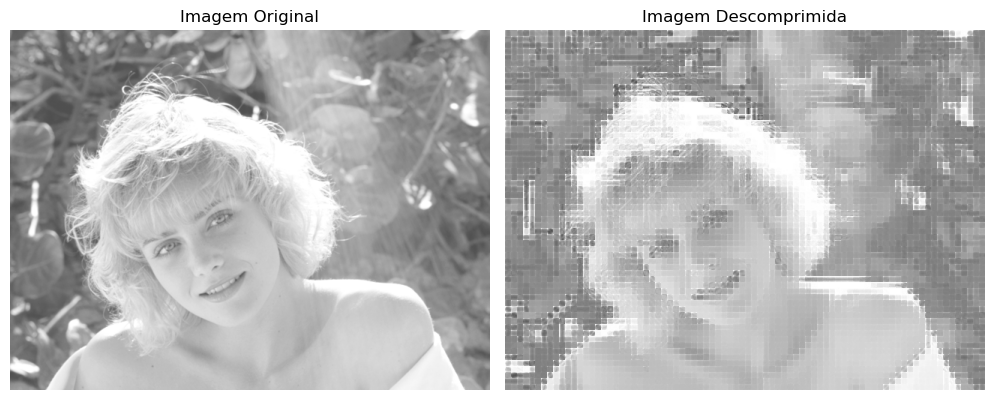

In [30]:
# Descompressão
img_path = 'images/compressed/marcie_comprimida_jpeg_dft.huff'
img_rec = dft_jpeg_descompression(img_path, QM_DFT)

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Descomprimida
plt.subplot(1, 3, 2)
plt.imshow(img_rec, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Descomprimida')
plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
# Métricas de Erro
rmse = rmse_metric(img, img_rec)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, img_rec)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 23.94596803174591
Métrica PSNR: 20.54615564112101 dB


## Comparação entre a compressão JPEG classica e a compressão utilizando a transformada DFT

Durante os testes, é perceptível que a compressão JPEG classica, que utiliza a transformada DCT, obteve um maior desempenho do que a compressão utilizando DFT. Isto ocorre por a compressão com DFT ter de guardar duas matrizes ao invés de uma no header do arquivo. Além disso, durante a realização do trabalho foi encontrado um problema em realação a transformada DFT: Quando realizado o processo de quantização na matriz de fase da transformada, a reconstrução sofria distorções, porém, não quantizar a matriz de fase resulta em uma taxa de compressão ruim. Levando isto em consideração, foi optado por permitir a quantização da matriz de fase e deixar os resultados do teste no notebook para visualização.

## Implementação da Codificação Preditiva e matriz de resíduos

Esta etapa realiza a **Codificação Preditiva** em uma imagem em escala de cinza, gerando uma matriz de resíduos,
bem como sua inversa, e avalia a qualidade da reconstrução utilizando as métricas **RMSE** e **PSNR**.
Nossa implementação é feita a partir de uma função de alta ordem, assim,
é possível definir variados preditores e suas inversas para obter resultados distintos.

---

- Funções

  - `prediction_comp(func, img)`
  Aplica a codificação preditiva na imagem, utilizando o preditor.

    - **Parâmetros:**
      - `func`: funcão preditora. Recebe como entradas o par de coordenadas x e y do pixel a ser predito, e a imagem original.
      - `img`: A imagem original a ser codificada.
    - **Retorna:** matriz de resíduos da codificação.


  - `prediction_decomp(func_inv, residual)`
  Aplica a **transformada inversa DCT (IDCT)** para reconstruir a imagem a partir dos coeficientes DCT.

    - **Parâmetros:**
      - `func_inv`: função inversa da preditora.

        Essa função recebe como entradas o par de coordenadas x e y do pixel a ser recuperado, a matriz de resíduos, e a recomposição parcial da imagem.
      - `residual`: matriz de resíduos da codificação preditiva.
    - **Retorna:** imagem reconstruída.

---

- Processamento

  1. **Aplicação da Codificação e Inversa:**
    - A função passa por todos os pixels e chama a função preditora, ou sua inversa.

---

- Visualização

  Exibe 3 imagens lado a lado:
    1. **Imagem Original**
    2. **Imagem Reconstruída**
    3. **Resíduos**

---

- Avaliação

    Duas métricas quantitativas são calculadas para medir a qualidade do processo:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio da reconstrução, deve ser 0, já que o método é sem perdas.
    2. Entropia `calcEntropy(img)`: Entropia da imagem, indica o número mínimo de bits por pixel necessários para representar a imagem,
        reflete a taxa de variação da imagem.

In [32]:
def prediction_comp(func, img):
    size = img.shape
    residual = np.zeros(size, int)
    img = img.astype(int)
    
    for y in range(0, size[0]):
        for x in range(0, size[1]):
            residual[y, x] = func(x, y, img)

    return residual

def prediction_decomp(func_inv, residual):
    size = residual.shape
    reconstructed = np.zeros(size, int)
    residual = residual.astype(int)
    
    for y in range(0, size[0]):
        for x in range(0, size[1]):
            reconstructed[y, x] = func_inv(x, y, reconstructed, residual)

    return reconstructed

In [33]:
def previous(x, y, img):
    if (x == 0):
        return img[y, x]
    return  img[y, x] - img[y, x-1]

def previous_inv(x, y, recons, residual):
    if (x==0):
        return residual[y,x]
    return recons[y, x-1] + residual[y, x]

In [34]:
# Aplicação das Funções
img = imagem.copy()

residual = prediction_comp(previous, img)
rebuilt = prediction_decomp(previous_inv, residual)

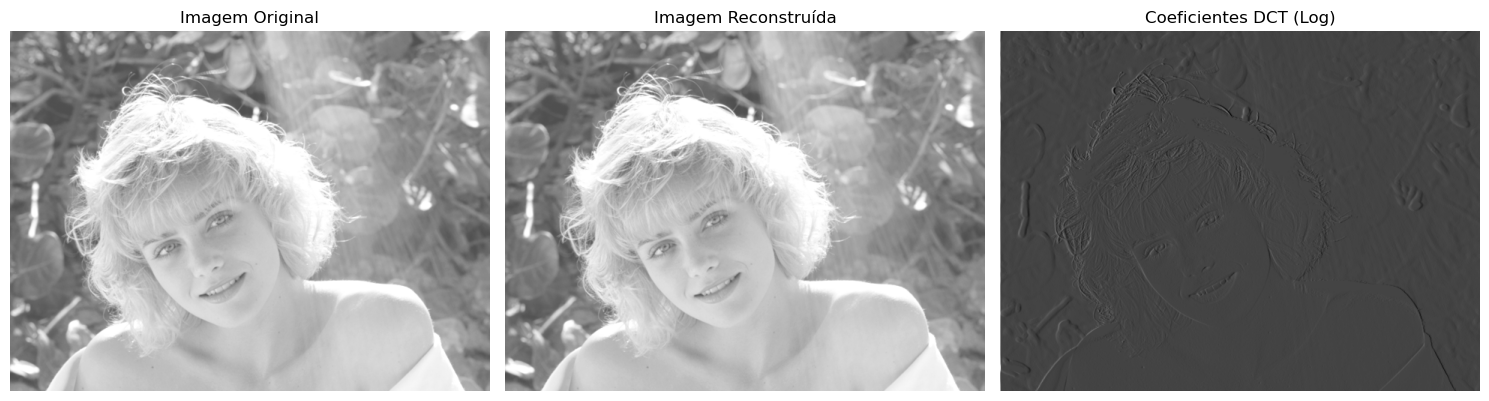

Entropia da imagem original: 7.1393776
Entropia da imagem de resíduos 4.018912
Erro da reconstrução: 0.0


In [35]:
# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(rebuilt, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

# Coeficientes DCT
plt.subplot(1, 3, 3)
plt.imshow(residual, cmap='gray')
plt.title('Coeficientes DCT (Log)')
plt.axis('off')

plt.tight_layout()
plt.show()

# image entropy
def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

# Root Mean Square Error
def rmse_metric(img1, img2):
    return np.sqrt(np.mean((img1.astype("float") - img2.astype("float")) ** 2))
    
# Valores de Entropia

#Transformação nos valores da matriz de resíduos, possui valores negativos
min_val = np.min(residual)
shifted = (residual - min_val).astype(np.uint8)

print("Entropia da imagem original:", calcEntropy(imagem))
print("Entropia da imagem de resíduos", calcEntropy(shifted))
rmse = rmse_metric(imagem, rebuilt)
print(f"Erro da reconstrução: {rmse}")

## Avaliação de Outras funções preditoras

Esta etapa realiza a **Codificação Preditiva** em uma imagem em escala de cinza, gerando uma matriz de resíduos,
bem como sua inversa, e avalia a qualidade da reconstrução utilizando as métricas **RMSE** e **PSNR**.
Nossa implementação é feita a partir de uma função de alta ordem, assim,
é possível definir variados preditores e suas inversas para obter resultados distintos.

---

- Funções

  - `previous`: Realiza a predição baseada no valor do pixel anterior.
 
<table style="border-collapse: collapse;">
  <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
  <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: green; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
  <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
    <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
    <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
</table>

  - `square`: Usa a média de um quadrado 3x3 antes do pixel desejado.

<table style="border-collapse: collapse;">
  <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
  <tr>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
  <tr>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
    <tr>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: green; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
    <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
</table>


  - `prev3`: Usa a média dos valores dos 3 pixels mais próximos e anteriores ao predito.

<table style="border-collapse: collapse;">
  <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
  <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
  <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
    <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: red; border: 1px solid black;"></td>
    <td style="background-color: green; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
    <tr>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
    <td style="background-color: white; border: 1px solid black;"></td>
  </tr>
</table>

---

- Processamento

  1. **Aplicação da Codificação e Inversa:**
    - A função passa por todos os pixels e chama a função preditora, ou sua inversa.

---

- Avaliação

    Duas métricas quantitativas são calculadas para medir a qualidade do processo:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio da reconstrução, deve ser 0, já que o método é sem perdas.
    2. Entropia `calcEntropy(img)`: Entropia da imagem, indica o número mínimo de bits por pixel necessários para representar a imagem,
        reflete a taxa de variação da imagem.

In [36]:
def square(x, y, image):
    if (x <= 2 or y <= 2):
        return img[y, x]

    sq = np.zeros((3,3), int)
    sq[0] = image[y-3, x-3:x]
    sq[1] = image[y-2, x-3:x]
    sq[2] = image[y-1, x-3:x]

    pred = np.floor(np.mean(sq))
    return img[y,x] - pred;

def square_inv(x, y, recons, residual):
    if (x <= 2 or y <= 2):
        return residual[y, x]

    sq = np.zeros((3,3), int)
    sq[0] = recons[y-3, x-3:x]
    sq[1] = recons[y-2, x-3:x]
    sq[2] = recons[y-1, x-3:x]
    pred = np.floor(np.mean(sq))

    return residual[y, x] + pred

def prev3(x, y, image):
    if (x < 1 or y < 1):
        return img[y, x]

    sq = np.zeros(3, int)
    sq[0:2] = image[y-1, x-1:x+1]
    sq[2] = image[y, x-1]

    pred = np.floor(np.mean(sq))
    return image[y,x] - pred;

def prev3_inv(x, y, recons, residual):
    if (x < 1 or y < 1):
        return residual[y, x]

    sq = np.zeros(3, int)
    sq[0:2] = recons[y-1, x-1:x+1]
    sq[2] = recons[y, x-1]

    pred = np.floor(np.mean(sq))
    return residual[y,x] + pred;

In [37]:
# Aplicação das Funções
img = imagem.copy()

residual_previous = prediction_comp(previous, img)
rebuilt_previous = prediction_decomp(previous_inv, residual)

residual_square = prediction_comp(square, img)
rebuilt_square = prediction_decomp(square_inv, residual)

residual_prev3= prediction_comp(prev3, img)
rebuilt_prev3 = prediction_decomp(prev3_inv, residual)

In [38]:
#Transformação nos valores da matriz de resíduos, possui valores negativos
min_val = np.min(residual_previous)
shifted_previous = (residual_previous - min_val).astype(np.uint8)

min_val = np.min(residual_square)
shifted_square = (residual_square - min_val).astype(np.uint8)

min_val = np.min(residual_prev3)
shifted_prev3 = (residual_prev3 - min_val).astype(np.uint8)

print("Entropia da imagem original:", calcEntropy(imagem))
print("Entropia da imagem de resíduos \"sprevious\"", calcEntropy(shifted_previous))
print("Entropia da imagem de resíduos \"square\"", calcEntropy(shifted_square))
print("Entropia da imagem de resíduos \"prev3\"", calcEntropy(shifted_prev3))

Entropia da imagem original: 7.1393776
Entropia da imagem de resíduos "sprevious" 4.018912
Entropia da imagem de resíduos "square" 5.202552
Entropia da imagem de resíduos "prev3" 3.9574394


## Funções de compressão e descompressão usando a transformada DFT

### Compressão e Descompressão sem perdas com Predição e Huffman

Nesta etapa do trabalho é simulo o processo de compressão e descompressão de uma imagem utilizando:

- **Codificação Preditiva**
- **Codificação de Huffman**

---

- `dft_jpeg_compression(img, file_name, QM, step=8)`  
    Realiza a **compressão de imagem** utilizando **Codificação Preditiva** e **codificação Huffman**.

    - **Parâmetros:**
        - `img`: imagem de entrada (matriz NumPy).
        - `path`: nome do arquivo `.huff` onde os dados comprimidos serão salvos.
        - `func`: função de predição.
    - **Processo:**
        1. Gera a *matriz de resíduos* com *Codificação Preditiva*.
        4. Codifica a **imagem de resíduos**  com **Huffman** (`huffman_encode`).
        5. Armazena os dados comprimidos (bitarrays, códigos e shapes) em um arquivo `.pkl` usando `pickle`.
    - **Retorna:**
        - Nenhum valor é retornado. A imagem comprimida é salva em `images/compressed/<file_name>`.

- `dft_jpeg_descompression(img_path, QM, step=8)`  
    Reconstrói a **imagem original** a partir de um arquivo comprimido `.pkl` gerado com `dft_jpeg_compression`.

    - **Parâmetros:**
        - `img_path`: caminho para o arquivo `.huff` com os dados comprimidos.
        - `func_inv`: inversa da função utilizada para predição
          
    - **Processo:**
        1. Carrega os dados comprimidos (`pickle.load`).
        2. Decodifica a **magnitude** e a **fase** com Huffman (`huffman_decode`).]
        3. Recupera a imagem com a inversa da preditora

    - **Retorna:**
        - `img_rec`: imagem reconstruída após descompressão.

---

- Visualização

    Mostra lado a lado:
    - A imagem original (`img`)
    - A imagem descomprimida (`img_rec`)

---

- Avaliação
  
    1. Taxa de compressão total: `Tamanho Original / Tamanho comprimido`
    2. Taxa de compressão desconsiderando o tamanho do dicionário, apenas a imagem gerada

In [39]:
def pred_huff_comp(func, image, path):
    residual = prediction_comp(func, image)
    
    codigos_huffman, dados_codificados = huffman_encode(residual)

    # Salvando dados comprimidos:
    dados_comprimidos = {
        'dados_codificados': dados_codificados,
        'codigos_huffman': codigos_huffman,
        'shape': residual.shape
    }
    
    path = os.path.join('images/compressed', file_name)
    dump(dados_comprimidos, path)

def pred_huff_decomp(func_inv, path):
    dados_comprimidos = load(img_path)

    residual = huffman_decode(dados_comprimidos)
    
    img_rec = prediction_decomp(func_inv, residual)

    return img_rec

In [40]:
# Compressão
img = imagem.copy()
img = img.astype(float)

file_name = 'marcie_comprimida_pred_huff.huff'

pred_huff_comp(previous, img, file_name)

dict_keys(['dados_codificados', 'codigos_huffman', 'shape'])
Dados comprimidos salvos em images/compressed/marcie_comprimida_pred_huff.huff


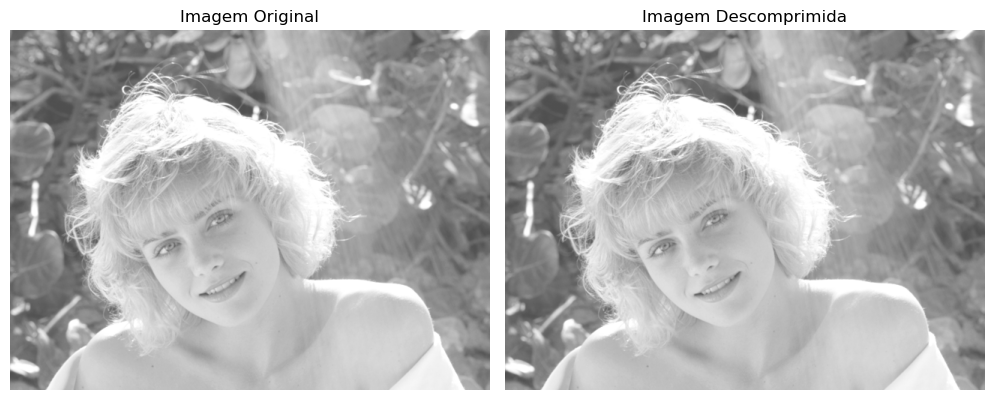

Taxa de compressão (com overhead) = 1.9129441213464675
Taca de compressão (sem overhead) =  1.9761611470437828


In [41]:
# Descompressão
img_path = 'images/compressed/marcie_comprimida_pred_huff.huff'
img_rec = pred_huff_decomp(previous_inv, img_path)

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Descomprimida
plt.subplot(1, 3, 2)
plt.imshow(img_rec, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Descomprimida')
plt.axis('off')

plt.tight_layout()
plt.show()

with open("images/compressed/marcie_comprimida_pred_huff.huff", 'rb') as f:    
    data = pickle.load(f)
    codes_size = data['dados_codificados'][1]
    codes = data['dados_codificados'][0]

# Taxa de compressão
original_size = os.path.getsize("images/pgm_bin/marcie.pgm") 
compressed_size = os.path.getsize("images/compressed/marcie_comprimida_pred_huff.huff")
taxa_de_compressao = original_size / compressed_size

#print(original_size, compressed_size, codes_size)
print(f"Taxa de compressão (com overhead) = {taxa_de_compressao}")
print(f"Taca de compressão (sem overhead) = ", original_size / (codes_size/8))